# 🏈 Visualise & Analyse NFL Player Movements

- This notebook provides tools to explore plays from the "NFL Big Data Bowl 2026"
- You can animate player movements for any chosen game and play

The animations may take a few seconds to load!

### Please link this notebook if you reuse my code ❤

I also have a starter notebook available here (beginner friendly): https://www.kaggle.com/code/danpietrow/lgbm-baseline-1-00-lb-beginner-friendly-starter

### Screenshot example:

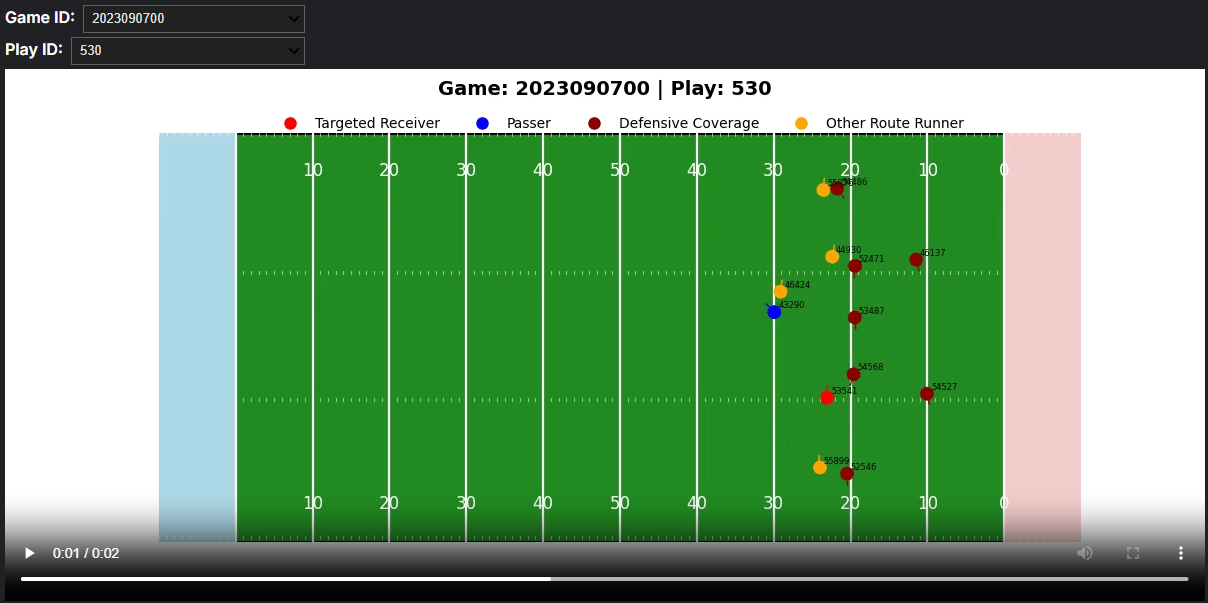

# Dependencies

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

rc('animation', html='jshtml')

# Load Data

In [2]:
DATA_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction/"

input_files = sorted(glob.glob(os.path.join(DATA_DIR, "train/input_2023_w*.csv")))
output_files = sorted(glob.glob(os.path.join(DATA_DIR, "train/output_2023_w*.csv")))

df_in = pd.concat((pd.read_csv(p) for p in tqdm(input_files, desc="loading inputs")), ignore_index=True)
df_out = pd.concat((pd.read_csv(p) for p in tqdm(output_files, desc="loading outputs")), ignore_index=True)

test_in = pd.read_csv(os.path.join(DATA_DIR, "test_input.csv"))
test_template = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

print("Inputs:", df_in.shape, "Outputs:", df_out.shape, "Test input:", test_in.shape)

loading inputs:   0%|          | 0/18 [00:00<?, ?it/s]

loading outputs:   0%|          | 0/18 [00:00<?, ?it/s]

Inputs: (4880579, 23) Outputs: (562936, 6) Test input: (49753, 23)


# Animation Helper Functions

In [3]:
ROLE_COLORS = {
    "Targeted Receiver": "red",
    "Passer": "blue",
    "Defensive Coverage": "darkred",
    "Other Route Runner": "orange",
}

def draw_field(ax, start_x=0.0, end_x=120.0, play_direction="right"):
    """Draw an NFL field with endzones, yard lines, and hash marks."""
    field_len = end_x - start_x
    left_goal, right_goal = start_x + 10.0, end_x - 10.0

    # Field + endzones
    if play_direction == "right":
        left_color, right_color = "lightblue", "#f4cccc"
    else:
        left_color, right_color = "#f4cccc", "lightblue"
    ax.add_patch(Rectangle((start_x, 0), field_len, 53.3, facecolor='forestgreen', edgecolor='black', lw=2, zorder=0))
    ax.add_patch(Rectangle((start_x, 0), 10, 53.3, facecolor=left_color, zorder=1))
    ax.add_patch(Rectangle((end_x - 10, 0), 10, 53.3, facecolor=right_color, zorder=1))

    # Sideline ticks
    for x in np.arange(start_x, end_x + 0.1, 1.0):
        for y in [0.4, 53.3 - 0.4]:
            ax.plot([x, x], [y, y + 0.5], color='white', lw=0.4, zorder=2)

    # Yard lines
    for x in np.arange(start_x + 10.0, end_x, 10.0):
        ax.plot([x, x], [0, 53.3], color='white', lw=1.6, zorder=2)

    # Yard numbers
    num_positions = np.arange(start_x + 20.0, end_x - 9.99, 10.0)
    for p in num_positions:
        d = p - left_goal
        label = int(min(d, 100.0 - d))
        ax.text(p, 5, str(label), color='white', fontsize=12, ha='center', va='center')
        ax.text(p, 53.3 - 5, str(label), color='white', fontsize=12, ha='center', va='center')

    # Inbounds hash marks (subtle, semi-transparent)
    hash_y = [18.37, 34.93]
    for x in np.arange(start_x + 10, end_x - 10 + 0.1, 1.0):
        for y in hash_y:
            ax.plot([x, x], [y, y + 0.4], color='white', lw=0.8, alpha=0.5, zorder=2)

    # Limits / aspect
    ax.set_xlim(start_x, end_x)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal')
    ax.axis('off')


def draw_legend(ax):
    """Legend for player roles."""
    handles = [Line2D([0], [0], marker='o', color='w', label=role,
                      markerfacecolor=color, markersize=10)
               for role, color in ROLE_COLORS.items()]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.07),
              ncol=len(handles), framealpha=0.9, frameon=False)


def animate_play(game_id, play_id, df_in, df_out,
                 show_output=True, figsize=(12, 5.33), save_path=None, subsample=1,
                 orientation_length=1.5):
    """Animate player movements for a single play with orientation as lines."""
    in_play = df_in.query("game_id==@game_id & play_id==@play_id").sort_values("frame_id")
    out_play = df_out.query("game_id==@game_id & play_id==@play_id").sort_values("frame_id")
    play_dir = in_play.play_direction.iloc[0]

    if subsample > 1:
        in_play = in_play[in_play["frame_id"] % subsample == 0]
        if not out_play.empty:
            out_play = out_play[out_play["frame_id"] % subsample == 0]

    # Build frames
    frames = []
    for _, grp in in_play.groupby("frame_id"):
        frames.append([dict(x=r.x, y=r.y,
                            color=ROLE_COLORS.get(r.player_role, 'gray'),
                            nfl_id=r.nfl_id,
                            o=getattr(r, "o", None))  # include orientation
                       for _, r in grp.iterrows()])

    if show_output and not out_play.empty:
        ball_x = in_play.ball_land_x.iloc[0]
        ball_y = in_play.ball_land_y.iloc[0]
        
        out_with_role = out_play.merge(
            in_play[['game_id', 'play_id', 'nfl_id', 'player_role']], 
            on=['game_id','play_id','nfl_id'], 
            how='left'
        )
        
        for frame_id, grp in out_with_role.groupby("frame_id"):
            frame_data = [
                dict(
                    x=r.x,
                    y=r.y,
                    color=ROLE_COLORS.get(r.player_role, 'gray'),
                    nfl_id=r.nfl_id,
                    o=None 
                ) for _, r in grp.iterrows()
            ]
            
            # add the ball
            frame_data.append(dict(
                x=ball_x,
                y=ball_y,
                color='black',
                nfl_id="BALL",
                size=50,
                zorder=1,
                marker='X'
            ))
            frames.append(frame_data)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    draw_field(ax, play_direction=play_dir)
    draw_legend(ax)
    fig.suptitle(f"Game: {game_id} | Play: {play_id}", fontsize=14, fontweight="bold", y=0.98)

    scat = ax.scatter([], [], s=80, zorder=5)
    max_players = max(len(f) for f in frames)
    texts = [ax.text(0, 0, "", fontsize=6, zorder=6) for _ in range(max_players)]
    orientation_lines = [ax.plot([], [], lw=1, zorder=4)[0] for _ in range(max_players)]

    def init():
        scat.set_offsets(np.zeros((0, 2)))
        for line in orientation_lines:
            line.set_data([], [])
        return (scat, *texts, *orientation_lines)

    def update(i):
        coords = np.array([[p['x'], p['y']] for p in frames[i]])
        scat.set_offsets(coords)
        scat.set_color([p['color'] for p in frames[i]])
    
        for idx, (t, line, p) in enumerate(zip(texts, orientation_lines, frames[i])):
            # text
            t.set_position((p['x'] + 0.5, p['y'] + 0.5))
            try:
                label = str(int(p['nfl_id']))
            except (ValueError, TypeError):
                label = str(p['nfl_id'])
            t.set_text(label)
            t.set_fontsize(6)
            t.set_fontweight('normal')
            t.set_visible(True)
    
            # orientation line only if orientation exists
            if p.get('o') is not None and not pd.isna(p['o']):
                angle_rad = np.deg2rad(p['o'])
                length = orientation_length

                # Thank you Robert Hatch for correcting
                x_end = p['x'] + length * np.sin(angle_rad)
                y_end = p['y'] + length * np.cos(angle_rad)
                
                line.set_data([p['x'], x_end], [p['y'], y_end])
                line.set_color(p['color'])  
                line.set_visible(True)
            else:
                line.set_data([], [])
                line.set_visible(False)
    
        for t in texts[len(frames[i]):]:
            t.set_visible(False)
        for line in orientation_lines[len(frames[i]):]:
            line.set_visible(False)
    
        return (scat, *texts, *orientation_lines)

    anim = animation.FuncAnimation(fig, update, frames=len(frames),
                                   init_func=init, blit=True, interval=100)

    plt.close(fig)
    if save_path:
        anim.save(save_path, fps=10, dpi=150)
        print(f"Saved animation to {save_path}")
    else:
        return anim


# Play single animation

In [4]:
SUBSAMPLE = 1 # Optional subsampling (e.g. use 2 to keep every 2nd frame for speed)

GAME_ID = df_in['game_id'].iloc[1]
PLAY_ID = df_in.query("game_id==@GAME_ID")['play_id'].iloc[1]

anim = animate_play(GAME_ID, PLAY_ID, df_in, df_out, subsample=SUBSAMPLE)
HTML(anim.to_html5_video())

# Interactive visualisation
- This may take a few seconds to update & you may need to create a copy of the notebook to use this

In [5]:
SUBSAMPLE = 1 # Optional subsampling (e.g. use 2 to keep every 2nd frame for speed)

In [6]:
game_selector = widgets.Dropdown(
    options=df_in['game_id'].unique(),
    description='Game ID:',
)

play_selector = widgets.Dropdown(
    options=[],
    description='Play ID:',
)

def update_play_options(*args):
    plays = df_in.query("game_id==@game_selector.value")['play_id'].unique()
    play_selector.options = plays

game_selector.observe(update_play_options, 'value')

output_widget = widgets.Output()

def show_animation(*args):
    with output_widget:
        clear_output(wait=True)
        anim = animate_play(game_selector.value, play_selector.value, df_in, df_out, subsample=SUBSAMPLE)
        display(HTML(anim.to_html5_video()))

play_selector.observe(show_animation, 'value')

display(game_selector, play_selector, output_widget)
update_play_options()  

Dropdown(description='Game ID:', options=(2023090700, 2023091000, 2023091001, 2023091002, 2023091003, 20230910…

Dropdown(description='Play ID:', options=(), value=None)

Output()